In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/

/content/drive


In [3]:
cd 'My Drive'

/content/drive/My Drive


In [4]:
cd 'Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


**Dataset description**

The dataset I am using is derived from IBM Sample Datasets.

*Context of the dataset*- It has columns about customer's demographic information, different types of services they are availing from the telecom company in question and customer churn(that is whether or not the customer leaves). This data is relevant to one whole month and our target variable is churn=1 (Yes) meaning the customer left the company

So, on the basis of information contained in the predictor variables, our goal is to identify customers who may tend to leave in order to focus on customer retention programs

**Metric used for evaluating models**- Recall score

**Explanation:** Since this is a customer churn prediction problem, we cannot afford to lose customers by classifying True Positives as Negatives- that is we need to minimise the number of False Negatives(customers who will leave (churn=1) but are classified as customers who won't leave(churn=0)). That is why I used recall, since it focusses on minimising False Negatives.


NOTE: False Positives won't cost the company as large as a leaving customer would. On the other hand, it benefit the company only since it will keep it's service-quality up to the mark for a sample that was falsely classified as positive.

Best model based on recall score: Cost Sensitive Random Forest Classifier

Recall score: 0.78

Test accuracy: 0.72


NOTE: Best model based on test accuracy is cost sensitive logistic regression model with accuracy=0.81 and recall=0.51

In [5]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


pd.pandas.set_option('display.max_columns', None)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# loading dataset
data = pd.read_csv('Customer Churn latest 2.csv')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        6696 non-null   object 
 1   gender            6704 non-null   object 
 2   SeniorCitizen     6712 non-null   float64
 3   Partner           6683 non-null   object 
 4   Dependents        6673 non-null   object 
 5   tenure            6693 non-null   float64
 6   PhoneService      6664 non-null   object 
 7   MultipleLines     6676 non-null   object 
 8   InternetService   6694 non-null   object 
 9   OnlineSecurity    6685 non-null   object 
 10  OnlineBackup      6724 non-null   object 
 11  DeviceProtection  6700 non-null   object 
 12  TechSupport       6657 non-null   object 
 13  StreamingTV       6684 non-null   object 
 14  StreamingMovies   6712 non-null   object 
 15  Contract          6711 non-null   object 
 16  PaperlessBilling  6691 non-null   object 


Here, the total number of records is 7043

By looking at the number of non-null values for different predictors, we can say that 5-10% of values are missing

In [11]:
print(data['Churn'].value_counts())

0    5174
1    1869
Name: Churn, dtype: int64


This shows that almost 73% of customers were retained(Churn=0) whereas 27% of them were not(Churn=1), suggesting that the dataset is imbalanced

Hence, the dataset satisfies all the required criteria

**Data Preprocessing**

In [299]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0.0,Yes,No,1.0,No,No phone service,DSL,No,NaN,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,NaN,0
1,5575-GNVDE,Male,0.0,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,NaN,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0.0,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,NaN,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0.0,No,No,2.0,Yes,NaN,NaN,No,No,No,No,No,No,NaN,Yes,Electronic check,70.70,151.65,1


In [0]:
data= data.drop(['customerID'], axis=1)

Identifying different types of variables

In [9]:
categorical = [var for var in data.columns if data[var].dtype == 'O']

temporal = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in temporal
]

continuous = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in temporal
]

print(f'There are {len(continuous)} continuous variables')
print(f'There are {len(discrete)} discrete variables')
print(f'There are {len(temporal)} temporal variables')
print(f'There are {len(categorical)} categorical variables')

There are 3 continuous variables
There are 2 discrete variables
There are 0 temporal variables
There are 15 categorical variables


In [10]:
print(discrete)

['SeniorCitizen', 'Churn']


In [11]:
print(categorical)

['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [12]:
print(continuous)

['tenure', 'MonthlyCharges', 'TotalCharges']


Inspecting variable values

In [17]:
for var in discrete:
    print(var, data[var].unique(), '\n')

SeniorCitizen [ 0. nan  1.] 

Churn [0 1] 



In [18]:
for var in categorical:
    print(var, data[var].unique(), '\n')

gender ['Female' 'Male' nan] 

Partner ['Yes' 'No' nan] 

Dependents ['No' 'Yes' nan] 

PhoneService ['No' 'Yes' nan] 

MultipleLines ['No phone service' 'No' nan 'Yes'] 

InternetService ['DSL' nan 'Fiber optic' 'No'] 

OnlineSecurity ['No' 'Yes' nan 'No internet service'] 

OnlineBackup [nan 'No' 'Yes' 'No internet service'] 

DeviceProtection ['No' 'Yes' nan 'No internet service'] 

TechSupport ['No' 'Yes' 'No internet service' nan] 

StreamingTV ['No' 'Yes' 'No internet service' nan] 

StreamingMovies ['No' 'Yes' nan 'No internet service'] 

Contract ['Month-to-month' 'One year' nan 'Two year'] 

PaperlessBilling ['Yes' 'No' nan] 

PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)' nan] 



In [307]:
for var in categorical:
  print(data[var].value_counts())
  print()

Male      3388
Female    3316
Name: gender, dtype: int64

No     3442
Yes    3241
Name: Partner, dtype: int64

No     4681
Yes    1992
Name: Dependents, dtype: int64

Yes    6019
No      645
Name: PhoneService, dtype: int64

No                  3228
Yes                 2794
No phone service     654
Name: MultipleLines, dtype: int64

Fiber optic    2948
DSL            2297
No             1449
Name: InternetService, dtype: int64

No                     3315
Yes                    1928
No internet service    1442
Name: OnlineSecurity, dtype: int64

No                     2957
Yes                    2314
No internet service    1453
Name: OnlineBackup, dtype: int64

No                     2947
Yes                    2301
No internet service    1452
Name: DeviceProtection, dtype: int64

No                     3286
Yes                    1935
No internet service    1436
Name: TechSupport, dtype: int64

No                     2676
Yes                    2558
No internet service    1450
Name: S

Plotting histograms for continuous variables

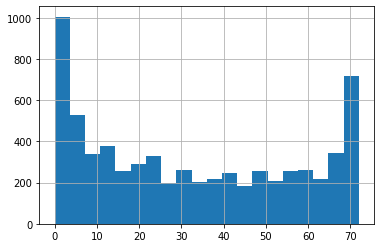

In [0]:
data['tenure'].hist(bins=20)

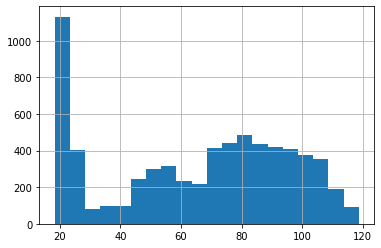

In [0]:
data['MonthlyCharges'].hist(bins=20)

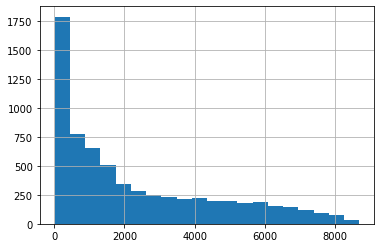

In [0]:
data['TotalCharges'].hist(bins=20)

Examining correlation between predictors and target variable- customer churn

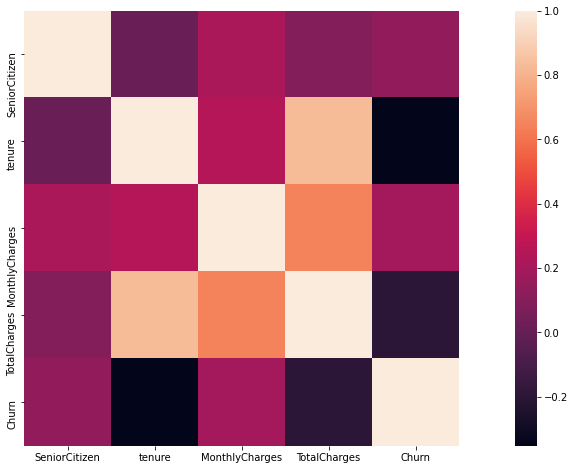

In [322]:
import seaborn as sns
f, ax = plt.subplots(figsize=(20, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), square=True, ax=ax
)

In [323]:
target_corr= data.corr()
target_corr['Churn'].sort_values(ascending=False)

Churn             1.000000
MonthlyCharges    0.198186
SeniorCitizen     0.139342
TotalCharges     -0.195570
tenure           -0.353031
Name: Churn, dtype: float64

Quantifying missing data

In [13]:
data.isnull().sum()

gender              339
SeniorCitizen       331
Partner             360
Dependents          370
tenure              350
PhoneService        379
MultipleLines       367
InternetService     349
OnlineSecurity      358
OnlineBackup        319
DeviceProtection    343
TechSupport         386
StreamingTV         359
StreamingMovies     331
Contract            332
PaperlessBilling    352
PaymentMethod       361
MonthlyCharges      309
TotalCharges        375
Churn                 0
dtype: int64

In [14]:
#imputing the predictor variable SeniorCitizen with mode of the column, that is 0

mode_value = data['SeniorCitizen'].mode()
#print('mode value: ', mode_value)
data['SeniorCitizen'].fillna(0, inplace=True)
print(data['SeniorCitizen'])

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7038    0.0
7039    0.0
7040    0.0
7041    1.0
7042    0.0
Name: SeniorCitizen, Length: 7043, dtype: float64


Splitting the data into train and test sets

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Churn'], axis=1),
                                                    data['Churn'],
                                                    test_size=0.2,
                                                    random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5634, 19) (5634,)
(1409, 19) (1409,)


Transforming predictors using the feature engineering pipeline

In [16]:
!pip install feature_engine

     |████████████████████████████████| 8.7MB 5.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [0]:
# import relevant modules for feature engineering
from sklearn.pipeline import Pipeline
from feature_engine import missing_data_imputers as mdi
from feature_engine import categorical_encoders as ce
#from feature_engine.variable_transformers import YeoJohnsonTransformer
from sklearn.preprocessing import StandardScaler

In [0]:
churn_preprocess = Pipeline([
    #missing data imputation
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='median',
                                          variables=continuous)),
    
    ('imputer_cat', mdi.CategoricalVariableImputer(variables= categorical)),
    
    # categorical encoding 
     #('rare_label_enc', ce.RareLabelCategoricalEncoder(
         #tol=0.01,n_categories=6, variables=categorical)),
    ('categorical_enc', ce.OneHotCategoricalEncoder(variables = categorical)),
    
     # feature Scaling
    ('scaler', StandardScaler()),
    
    
])

In [19]:
churn_preprocess.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('imputer_num',
                 MeanMedianImputer(imputation_method='median',
                                   variables=['tenure', 'MonthlyCharges',
                                              'TotalCharges'])),
                ('imputer_cat',
                 CategoricalVariableImputer(imputation_method='missing',
                                            return_object=False,
                                            variables=['gender', 'Partner',
                                                       'Dependents',
                                                       'PhoneService',
                                                       'MultipleLines',
                                                       'InternetService',
                                                       'OnlineSecurity',
                                                       'OnlineB...
                 OneHotCategoricalEncoder(drop_last=False, top_categorie

In [0]:
# Apply Transformations
X_train=churn_preprocess.transform(X_train)
X_test=churn_preprocess.transform(X_test)

**Basic Algorithms**

Naive Algorithm

In [30]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import  recall_score
from sklearn.metrics import roc_auc_score

dummyModel = DummyClassifier(strategy='stratified',random_state=123)
dummyModel.fit(X_train,y_train)
cv_scores = cross_val_score(dummyModel, X_train, y_train,scoring='roc_auc')
predictions= dummyModel.predict(X_test)

# Mean Cross validation Score
print("Mean Cross-validation scores: {}".format(cv_scores.mean()))
print()
# Check test data set performance
print("Naive Algorithm Test Performance: ", dummyModel.score(X_test,y_test))

print()
print("Confusion matrix ")
print(confusion_matrix(y_test, predictions))
print()
print("Precision: ", precision_score(y_test, predictions))
print("Recall: ", recall_score(y_test, predictions))
print("ROC AUC: ", roc_auc_score(y_test, predictions))

Mean Cross-validation scores: 0.5016701459840778

Naive Algorithm Test Performance:  0.6039744499645139

Confusion matrix 
[[763 278]
 [280  88]]

Precision:  0.24043715846994534
Recall:  0.2391304347826087
ROC AUC:  0.48603976109927743


Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import  recall_score
from sklearn.metrics import roc_auc_score

clf = LogisticRegression().fit(X_train, y_train)

cv_scores = cross_val_score(clf, X_train, y_train)

y_pred_log= clf.predict(X_test)
# Mean Cross validation Score
print("Mean Cross-validation scores: {}".format(cv_scores.mean()))
print()

# Print Co-efficients
print("Logistic.coef_:", clf.coef_)
print("Logistic.intercept_:", clf.intercept_)

# Check test data set performance
print("Logistic Train Performance: ", clf.score(X_train,y_train))
print("Logistic Test Performance: ", clf.score(X_test,y_test))

print()
print("Confusion matrix ")
print(confusion_matrix(y_test, y_pred_log))
print()
print("Precision: ", precision_score(y_test, y_pred_log))
print("Recall: ", recall_score(y_test, y_pred_log))
print("ROC AUC: ", roc_auc_score(y_test, y_pred_log))

Mean Cross-validation scores: 0.7941082835172836

Logistic.coef_: [[ 0.06702349 -0.97803153  0.57921917  0.15275763  0.01305055 -0.01250472
  -0.00128411  0.01811243 -0.00583785 -0.02797139  0.05982811 -0.0671776
   0.00884115  0.0135108   0.00897475 -0.03291327 -0.11726455  0.17889669
  -0.00255793  0.01469092 -0.00422819 -0.21388521  0.17052307  0.0202972
  -0.20335311  0.03159311  0.16681539  0.03550199 -0.05408596  0.12774015
  -0.1048354   0.02288718 -0.03644363  0.024799    0.04333774 -0.06052044
  -0.04773889  0.18868894 -0.20727672  0.04700826 -0.0941669  -0.09171267
  -0.16967364  0.36428086  0.01904795  0.01109222 -0.06457308  0.03488629
  -0.31068946  0.28634374 -0.07325858  0.0753346  -0.0984579   0.08901162
   0.01727928 -0.02626432  0.12931151 -0.03034754 -0.08454584 -0.01548043]]
Logistic.intercept_: [-1.66902487]
Logistic Train Performance:  0.805111821086262
Logistic Test Performance:  0.794889992902768

Confusion matrix 
[[931 110]
 [179 189]]

Precision:  0.632107023

Decision Tree Classifier

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

#from sklearn.metrics import fbeta_score, make_scorer
#dtree = DecisionTreeClassifier(random_state=0)

ftwo_scorer = make_scorer(fbeta_score, beta=2)

#define a list of parameters
param_dtree = {'max_depth': range(1,6)}

#apply grid search
grid_dtree = GridSearchCV(dtree, param_dtree, cv=5, return_train_score = True)
grid_dtree.fit(X_train, y_train)

y_pred_tree= grid_dtree.predict(X_test)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_dtree.best_score_))
print()

#print("F2 score: {:.2f}".format(grid_dtree.ftwo_scorer))
print()
#find best parameters
print('Decision Tree parameters: ', grid_dtree.best_params_)

# Check test data set performance
print("Train Performance: ", grid_dtree.score(X_train,y_train))
print("Test Performance: ", grid_dtree.score(X_test,y_test))
print()

print("Recall: ", recall_score(y_test, y_pred_tree))




Best Mean Cross-validation score: 0.78


Decision Tree parameters:  {'max_depth': 4}
Train Performance:  0.7928647497337593
Test Performance:  0.7700496806245565

Recall:  0.40217391304347827


KNN Classifier

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

knn = KNeighborsClassifier()

# define a list of parameters

param_knn = {'n_neighbors': range(5,15)}

#apply grid search
grid_knn = GridSearchCV(knn, param_knn, cv=5, return_train_score=True)
grid_knn.fit(X_train, y_train)

y_pred= grid_knn.predict(X_test)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_knn.best_score_))
print()

#find best parameters
print('KNN parameters: ', grid_knn.best_params_)

# Check test data set performance
print("KNN Train Performance: ", grid_knn.score(X_train,y_train))
print("KNN Test Performance: ", grid_knn.score(X_test,y_test))
print()
print("Confusion matrix ")
print(confusion_matrix(y_test, y_pred))
print()
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))

Best Mean Cross-validation score: 0.77

KNN parameters:  {'n_neighbors': 12}
KNN Train Performance:  0.8047568335108272
KNN Test Performance:  0.7466288147622427

Confusion matrix 
[[896 145]
 [212 156]]

Precision:  0.5182724252491694
Recall:  0.42391304347826086
ROC AUC:  0.6423119492127134


Linear Support Vector Classifier

In [34]:
#Linear SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

linearSVC_parameters= { 
                'tol':[0.0001,0.001,0.01,1],
                'C':[0.1,1,10,100,1000]
}

linearSVC_gridSearch= GridSearchCV(LinearSVC(max_iter=10000),linearSVC_parameters, cv=3, return_train_score=True)

linearSVC_gridSearch.fit(X_train, y_train)

y_predSVC= linearSVC_gridSearch.predict(X_test)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(linearSVC_gridSearch.best_score_))
print()

#find best parameters
print('Support Vector Classifier parameters: ', linearSVC_gridSearch.best_params_)

# Check test data set performance
print("Support Vector Classifier Train Performance: ", linearSVC_gridSearch.score(X_train,y_train))
print("Support Vector Classifier Test Performance: ", linearSVC_gridSearch.score(X_test,y_test))
print()
print("Confusion matrix ")
print(confusion_matrix(y_test, y_predSVC))
print()
print("Precision: ", precision_score(y_test, y_predSVC))
print("Recall: ", recall_score(y_test, y_predSVC))
print("ROC AUC: ", roc_auc_score(y_test, y_predSVC))



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Best Mean Cross-validation score: 0.80

Support Vector Classifier parameters:  {'C': 10, 'tol': 1}
Support Vector Classifier Train Performance:  0.8008519701810437
Support Vector Classifier Test Performance:  0.794889992902768

Confusion matrix 
[[946  95]
 [194 174]]

Precision:  0.6468401486988847
Recall:  0.47282608695652173
ROC AUC:  0.6907838407885395


Random Forest Classifier

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
#from sklearn.metrics import make_scorer

#R_scorer = make_scorer(recall_score)


rnd_parameters= {'max_leaf_nodes':[4,8,16]}

rnd = RandomForestClassifier(random_state=0)
rndGridSearch= GridSearchCV(rnd, rnd_parameters, cv=3, return_train_score=True)

rndGridSearch.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(rndGridSearch.best_score_))
print()
y_pred_rf= rndGridSearch.predict(X_test)

#find best parameters
print('Random Forest Test Performance parameters: ', rndGridSearch.best_params_)

# Check test data set performance

print("Random Forest Train Performance: ", rndGridSearch.score(X_train, y_train) )
print("Random Forest Test Performance: ", rndGridSearch.score(X_test,y_test))
print()
print("Confusion matrix ")
print(confusion_matrix(y_test, y_pred_rf))
print()
print("Precision: ", precision_score(y_test, y_pred_rf ))
print("Recall: ", recall_score(y_test, y_pred_rf ))
print("ROC AUC: ", roc_auc_score(y_test, y_pred_rf))


Best Mean Cross-validation score: 0.79

Random Forest Test Performance parameters:  {'max_leaf_nodes': 16}
Random Forest Train Performance:  0.8029818956336529
Random Forest Test Performance:  0.7799858055358411

Confusion matrix 
[[966  75]
 [235 133]]

Precision:  0.6394230769230769
Recall:  0.36141304347826086
ROC AUC:  0.6446834669840871


Extra Trees Classifier

In [38]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

EXT_parameters= {'n_estimators':[50,100,500],
                  'max_depth':[6,7,8,9]}

EXTGridSearch= GridSearchCV( ExtraTreesClassifier(random_state=0), EXT_parameters, cv=3, return_train_score=True)

EXTGridSearch.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(EXTGridSearch.best_score_))
print()

#predicting houseprice
y_pred_ext= EXTGridSearch.predict(X_test)

#find best parameters
print('Extra Trees Test Performance parameters: ', EXTGridSearch.best_params_)

# Check test data set performance

print("Extra Trees Train Performance: ", EXTGridSearch.score(X_train, y_train) )
print("Extra Trees Test Performance: ", EXTGridSearch.score(X_test,y_test))
print()
print("Confusion matrix ")
print(confusion_matrix(y_test, y_pred_ext))
print()
print("Precision: ", precision_score(y_test, y_pred_ext ))
print("Recall:", recall_score(y_test, y_pred_ext ))
print("ROC AUC: ", roc_auc_score(y_test, y_pred_ext))

Best Mean Cross-validation score: 0.79

Extra Trees Test Performance parameters:  {'max_depth': 8, 'n_estimators': 100}
Extra Trees Train Performance:  0.8235711750088747
Extra Trees Test Performance:  0.7906316536550745

Confusion matrix 
[[956  85]
 [210 158]]

Precision:  0.6502057613168725
Recall: 0.42934782608695654
ROC AUC:  0.6738477843210959


Gradient Boosting

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

GB_parameters= { 'max_depth':[2,4],
                'learning_rate':[0.1,1.0]}

GB_gridSearch= GridSearchCV(GradientBoostingClassifier(random_state=42),GB_parameters, cv=5, return_train_score=True)

GB_gridSearch.fit(X_train, y_train)
# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(GB_gridSearch.best_score_))
print()

y_pred_GB= GB_gridSearch.predict(X_test)

#find best parameters
print('Gradient Boosting Test Performance parameters: ', GB_gridSearch.best_params_)

# Check test data set performance

print("Gradient Boosting Train Performance: ", GB_gridSearch.score(X_train, y_train) )
print("Gradient Boosting Test Performance: ", GB_gridSearch.score(X_test,y_test))
print()
print("Confusion matrix ")
print(confusion_matrix(y_test, y_pred_GB ))
print()
print("Precision score: ", precision_score(y_test, y_pred_GB ))
print("Recall score: ", recall_score(y_test, y_pred_GB ))
print("ROC AUC: ", roc_auc_score(y_test, y_pred_GB))


Best Mean Cross-validation score: 0.80

Gradient Boosting Test Performance parameters:  {'learning_rate': 0.1, 'max_depth': 2}
Gradient Boosting Train Performance:  0.8180688675896344
Gradient Boosting Test Performance:  0.7913413768630234

Confusion matrix 
[[938 103]
 [191 177]]

Precision score:  0.6321428571428571
Recall score:  0.48097826086956524
ROC AUC:  0.6910174685711898


XG Boost

In [27]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

xgb_parameters= {'learning_rate':[0.1,1,10],
                 'max_depth':[3,4,5],
                 'gamma':[0,0.1,1.0],
                 'alpha':[0,0.1,1.0],
                 'lambda':[0,1,10,100]}

xgbGridSearch= GridSearchCV( XGBClassifier(n_estimators=100,random_state=0, n_jobs=1), xgb_parameters, cv=3, return_train_score=True)

xgbGridSearch.fit(X_train,y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(xgbGridSearch.best_score_))
print()

#predicting houseprice
y_pred_xgb= xgbGridSearch.predict(X_test)

#find best parameters
print('XGB Test Performance parameters: ', xgbGridSearch.best_params_)

# Check test data set performance

print("XGB Train Performance: ", xgbGridSearch.score(X_train, y_train) )
print("XGB Test Performance: ", xgbGridSearch.score(X_test,y_test))
print()
print("Confusion matrix ")
print(confusion_matrix(y_test, y_pred_xgb ))
print()
print("Recall: ", recall_score(y_test, y_pred_xgb ))

Best Mean Cross-validation score: 0.80

XGB Test Performance parameters:  {'alpha': 0, 'gamma': 0.1, 'lambda': 0, 'learning_rate': 0.1, 'max_depth': 3}
XGB Train Performance:  0.8258785942492013
XGB Test Performance:  0.7920511000709723

Confusion matrix 
[[934 107]
 [186 182]]

Recall:  0.4945652173913043


Stacking Classifier

In [35]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

xgb_clf= XGBClassifier(alpha=0, gamma=0.1,learning_rate=0.1, max_depth=3)
ext_clf= ExtraTreesClassifier(max_depth=8, n_estimators=100)
gb_clf= GradientBoostingClassifier(learning_rate=0.1, max_depth=2)
rnd_clf= RandomForestClassifier(max_leaf_nodes=16)
svc_clf= SVC(C=10, tol=1)
knn_clf= KNeighborsClassifier(n_neighbors=12)
log_clf= LogisticRegression()


stacking_clf = StackingClassifier(estimators=[('XG Boost', xgb_clf), 
                                          ('Extra Trees', ext_clf), 
                                          ('Gradient Boosting', gb_clf),
                                          ('Random Forest',rnd_clf),
                                          ('Linear SVC',svc_clf ),
                                          ('knn', knn_clf),
                                          ('log', log_clf)])
stacking_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
for clf in (xgb_clf, ext_clf, gb_clf, rnd_clf, svc_clf , log_clf, knn_clf, stacking_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__)
    print('Recall:' ,recall_score(y_test, y_pred))
    print('Test accuracy: ',accuracy_score(y_test, y_pred))
    print()

XGBClassifier
Recall: 0.4945652173913043
Test accuracy:  0.7920511000709723

ExtraTreesClassifier
Recall: 0.41847826086956524
Test accuracy:  0.7920511000709723

GradientBoostingClassifier
Recall: 0.48097826086956524
Test accuracy:  0.7913413768630234

RandomForestClassifier
Recall: 0.33967391304347827
Test accuracy:  0.7771469127040455

SVC
Recall: 0.483695652173913
Test accuracy:  0.7487579843860894

LogisticRegression
Recall: 0.5135869565217391
Test accuracy:  0.794889992902768

KNeighborsClassifier
Recall: 0.42391304347826086
Test accuracy:  0.7466288147622427

StackingClassifier
Recall: 0.48097826086956524
Test accuracy:  0.7955997161107168



**Cost Sensitive Algorithms**

Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score

log = LogisticRegression(solver='lbfgs')
param_grid = {
    
    'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
}

#apply grid search
grid_log= GridSearchCV(log, param_grid, cv=5, n_jobs=2, scoring='roc_auc')
grid_log.fit(X_train, y_train)

y_pred_log= grid_log.predict(X_test)

print("Best parameters: {}".format(grid_log.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(grid_log.best_score_))
print('Training performance:', grid_log.score(X_train, y_train))
print('Test performance:', grid_log.score(X_test, y_test))
print('Recall:', recall_score(y_test, y_pred_log))

Best parameters: {'class_weight': {0: 1, 1: 1}}
Best Mean cross-validation score: 0.84
Training performance: 0.851835609875697
Test performance: 0.8160527085160589
Recall: 0.5135869565217391


Decision Tree Classifier

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score

dtree = DecisionTreeClassifier()
param_grid = {
    
    'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
    'max_depth': [2,3,4,5]
}

#apply grid search
grid_dtree= GridSearchCV(dtree, param_grid, cv=5, n_jobs=2, scoring='roc_auc')
grid_dtree.fit(X_train, y_train)

y_pred_tree= grid_dtree.predict(X_test)

print("Best parameters: {}".format(grid_dtree.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(grid_dtree.best_score_))
print('Training performance:', grid_dtree.score(X_train, y_train))
print('Test performance:', grid_dtree.score(X_test, y_test))
print('Recall:', recall_score(y_test, y_pred_tree))

Best parameters: {'class_weight': {0: 1, 1: 1}, 'max_depth': 4}
Best Mean cross-validation score: 0.82
Training performance: 0.8340666670642831
Test performance: 0.7968273608152696
Recall: 0.40217391304347827


Linear Support Vector Classifier

In [41]:
#Linear SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import recall_score

linearSVC_parameters= { 
                'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
                'tol':[0.0001,0.001,0.01,1],
                'C':[0.1,1,10,100,1000]
}

linearSVC_grid= GridSearchCV(LinearSVC(max_iter=10000),linearSVC_parameters, cv=3, return_train_score=True)

linearSVC_grid.fit(X_train, y_train)

y_predLSVC= linearSVC_grid.predict(X_test)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(linearSVC_grid.best_score_))
print()

#find best parameters
print('Support Vector Classifier parameters: ', linearSVC_grid.best_params_)

# Check test data set performance
print("Train Performance: ", linearSVC_grid.score(X_train,y_train))
print("Test Performance: ", linearSVC_grid.score(X_test,y_test))
print("Recall: ", recall_score(y_test, y_predLSVC))




/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Best Mean Cross-validation score: 0.80

Support Vector Classifier parameters:  {'C': 0.1, 'class_weight': {0: 1, 1: 1}, 'tol': 1}
Train Performance:  0.8013844515441959
Test Performance:  0.7998580553584103
Recall:  0.48097826086956524


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import recall_score

#from sklearn.metrics import make_scorer

#R_scorer = make_scorer(recall_score)


rnd_parameters= {'max_leaf_nodes':[4,8,16]}

rnd = RandomForestClassifier(class_weight='balanced_subsample', random_state=0)
rndGridSearch= GridSearchCV(rnd, rnd_parameters, cv=3, return_train_score=True)

rndGridSearch.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(rndGridSearch.best_score_))
print()
y_pred_rf= rndGridSearch.predict(X_test)

#find best parameters
print('Random Forest Test Performance parameters: ', rndGridSearch.best_params_)

# Check test data set performance

print("Random Forest Train Performance: ", rndGridSearch.score(X_train, y_train) )
print("Random Forest Test Performance: ", rndGridSearch.score(X_test,y_test))

print("Recall: ", recall_score(y_test, y_pred_rf ))


Best Mean Cross-validation score: 0.75

Random Forest Test Performance parameters:  {'max_leaf_nodes': 16}
Random Forest Train Performance:  0.7539936102236422
Random Forest Test Performance:  0.7281760113555713
Recall:  0.782608695652174


XG Boost

In [47]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import recall_score

xgb_param= {'scale_pos_weight': [1, 10, 25, 50, 75, 99, 100, 1000]}

xgb_grid= GridSearchCV( XGBClassifier(alpha=0, 
                                    gamma=0.1,  
                                    learning_rate=0.1, 
                                    max_depth=3, 
                                    n_estimators=100,
                                    random_state=0, 
                                    n_jobs=1), xgb_param, cv=3, return_train_score=True)

xgb_grid.fit(X_train,y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(xgb_grid.best_score_))
print()

#predicting houseprice
y_pred_xgboost= xgb_grid.predict(X_test)

#find best parameters
print('XGB Test Performance parameters: ', xgb_grid.best_params_)

# Check test data set performance

print("XGB Train Performance: ", xgb_grid.score(X_train, y_train) )
print("XGB Test Performance: ", xgb_grid.score(X_test,y_test))
print("Recall: ", recall_score(y_test, y_pred_xgboost ))

Best Mean Cross-validation score: 0.80

XGB Test Performance parameters:  {'scale_pos_weight': 1}
XGB Train Performance:  0.8258785942492013
XGB Test Performance:  0.7920511000709723
Recall:  0.4945652173913043


Extra Trees

In [63]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import recall_score


EXT_param= {'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]}

EXTGrid= GridSearchCV( ExtraTreesClassifier(max_depth=8, n_estimators=100, random_state=0), EXT_param, cv=3, return_train_score=True)

EXTGrid.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(EXTGrid.best_score_))
print()

#predicting houseprice
y_pred_ext= EXTGrid.predict(X_test)

#find best parameters
print('Extra Trees Test Performance parameters: ', EXTGrid.best_params_)

# Check test data set performance

print("Extra Trees Train Performance: ", EXTGrid.score(X_train, y_train) )
print("Extra Trees Test Performance: ", EXTGrid.score(X_test,y_test))
print("Recall:", recall_score(y_test, y_pred_ext ))


Best Mean Cross-validation score: 0.79

Extra Trees Test Performance parameters:  {'class_weight': {0: 1, 1: 1}}
Extra Trees Train Performance:  0.8235711750088747
Extra Trees Test Performance:  0.7906316536550745
Recall: 0.42934782608695654


Bagging decision tree with under sampling

In [52]:
!pip install imblearn

In [62]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

model= BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),sampling_strategy='not majority')

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1)

model.fit(X_train, y_train)

y_pred_model= model.predict(X_test)

print('Test performance:', accuracy_score(y_test, y_pred_model))
print('Recall:', recall_score(y_test, y_pred_model))


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Test performance: 0.7757274662881476
Recall: 0.391304347826087


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Data Sampling Algorithm

In [0]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from sklearn.metrics import recall_score

In [0]:
# define pipeline
rf = RandomForestClassifier()
pipe_rand_over = Pipeline([('over', RandomOverSampler()), ('model', RandomForestClassifier())])
pipe_rand_smote = Pipeline([('smote', SMOTE()), ('model', RandomForestClassifier())])
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [70]:
rf.fit(X_train, y_train)

pipe_rand_over.fit(X_train, y_train)

pipe_rand_smote.fit(X_train, y_train)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('model',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=No

In [0]:
y_pred_rf = rf.predict(X_test)
y_pred_ro = pipe_rand_over.predict(X_test)
y_pred_rs = pipe_rand_smote.predict(X_test)

In [73]:
from sklearn.metrics import recall_score

scores = cross_val_score(rf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
score = mean(scores)
print('F-measure: %.3f' % score)
print('Recall:', recall_score(y_test, y_pred_rf))

F-measure: 0.830
Recall: 0.4429347826086957


In [74]:
from sklearn.metrics import recall_score

scores = cross_val_score(pipe_rand_over, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
score = mean(scores)
print('F-measure: %.3f' % score)
print('Recall:', recall_score(y_test, y_pred_ro))

F-measure: 0.828
Recall: 0.5489130434782609


In [75]:
from sklearn.metrics import recall_score

scores = cross_val_score(pipe_rand_smote, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
score = mean(scores)
print('F-measure: %.3f' % score)
print('Recall:', recall_score(y_test, y_pred_rs))

F-measure: 0.827
Recall: 0.529891304347826
